<a href="https://colab.research.google.com/github/AlexandreAdam/ExoRIM/blob/dev/notebooks/exorim_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/AlexandreAdam/ExoRIM.git
%cd ExoRIM
!git checkout dev

Cloning into 'ExoRIM'...
remote: Enumerating objects: 513, done.
remote: Counting objects: 100% (513/513), done.
remote: Compressing objects: 100% (356/356), done.
remote: Total 1148 (delta 329), reused 316 (delta 156), pack-reused 635
Receiving objects: 100% (1148/1148), 21.08 MiB | 34.05 MiB/s, done.
Resolving deltas: 100% (720/720), done.
/content/ExoRIM
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'


In [2]:
!pip install wandb
!python setup.py develop
!pip install celluloid

     |████████████████████████████████| 2.1MB 18.9MB/s 
     |████████████████████████████████| 133kB 51.2MB/s 
     |████████████████████████████████| 102kB 13.3MB/s 
     |████████████████████████████████| 163kB 52.4MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=6858f5eda474e0e1a454e73cb7df5794eca0712c355f8a17caec67bc3a92babc
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=2a674209ebc731de304169a8238b4e10d0ad8ae51c14e31c3078618ab09911bd
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32
running develop
running egg_info
creating exorim.egg-info
writing exorim.egg-info/PKG-INFO
writing dependency_links to exorim.egg-info/dependency_l

In [3]:
from exorim import RIM, MSE, PhysicalModel
from preprocessing.simulate_data import create_and_save_data
from exorim.interferometry.simulated_data import CenteredBinaries 
from exorim.definitions import DTYPE, rad2mas
from exorim.utilities import create_dataset_from_generator, replay_dataset_from_generator
from exorim.interferometry.operators import Baselines
from exorim.interferometry.models.direct_fourier_transform import GOLAY9

from argparse import ArgumentParser
from datetime import datetime
import tensorflow as tf
import numpy as np
import json
import os
import wandb

import matplotlib.pyplot as plt
from glob import glob
from celluloid import Camera
import collections
import pickle
from IPython.display import HTML

import exorim.inference.log_likelihood as chisq

os.mkdir("logs")

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
def create_datasets(meta_data, rim, dirname, batch_size=None, index_save_mod=1, format="txt"):
    images = tf.convert_to_tensor(create_and_save_data(dirname, meta_data, index_save_mod, format), dtype=DTYPE)
    noisy_data = rim.physical_model.forward(images) # TODO make this noisy forward
    X = tf.data.Dataset.from_tensor_slices(noisy_data)  # split along batch dimension
    Y = tf.data.Dataset.from_tensor_slices(images)
    dataset = tf.data.Dataset.zip((X, Y))
    if batch_size is not None: # for train set
        dataset = dataset.batch(batch_size, drop_remainder=True)
        # dataset = dataset.enumerate(start=0)
        dataset = dataset.cache()  # accelerate the second and subsequent iterations over the dataset
        dataset = dataset.prefetch(AUTOTUNE)  # Batch is prefetched by CPU while training on the previous batch occurs
    else:
        # batch together all examples, for test set
        dataset = dataset.batch(images.shape[0], drop_remainder=True)
        dataset = dataset.cache()
    return dataset


In [5]:
parser = ArgumentParser()
parser.add_argument("--pixels", type=int, default=32)
parser.add_argument("--learning_rate", type=float, default=1e-2)
parser.add_argument("--decay_rate", type=float, default=0.95)
parser.add_argument("--decay_steps", type=int, default=50)
parser.add_argument("-n", "--number_images", type=int, default=1000)
parser.add_argument("-w", "--wavelength", type=float, default=0.5e-6)
parser.add_argument("--SNR", type=float, default=10, help="Signal to noise ratio")
parser.add_argument("-s", "--split", type=float, default=0.8)
parser.add_argument("-b", "--batch", type=int, default=50, help="Batch size")
# parser.add_argument("-t", "--training_time", type=float, default=2, help="Time allowed for training in hours")
# parser.add_argument("--adam_loglike_update", default=True)
parser.add_argument("-m", "--min_delta", type=float, default=0., help="Tolerance for early stopping")
parser.add_argument("-p", "--patience", type=int, default=10, help="Patience for early stopping") # infinite patience for hparam check
parser.add_argument("-c", "--checkpoint", type=int, default=5, help="Checkpoint to save model weights")
parser.add_argument("-e", "--max_epoch", type=int, default=50, help="Maximum number of epoch")
parser.add_argument("--index_save_mod", type=int, default=20, help="Image index to be saved")
parser.add_argument("--epoch_save_mod", type=int, default=1, help="Epoch at which to save images")
parser.add_argument("--noise_floor", type=float, default=1, help="Intensity noise floor")
parser.add_argument("--format", type=str, default="png", help="Format with which to save image, either png or txt")
parser.add_argument("--seed", type=float, default=42, help="Dataset seed")

args, unknown = parser.parse_known_args()
date = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
id = date
print(f"id = {id}")

basedir = os.getcwd()  # assumes script is run from base directory
results_dir = os.path.join(basedir, "results", id)
os.mkdir(results_dir)
models_dir = os.path.join(basedir, "models", id)
os.mkdir(models_dir)
data_dir = os.path.join(basedir, "data", id)
os.mkdir(data_dir)
train_dir = os.path.join(data_dir, "train")
os.mkdir(train_dir)
test_dir = os.path.join(data_dir, "test")
os.mkdir(test_dir)

# another approach to save results using tensorboard and wandb
logdir = os.path.join(basedir, "logs", id)
os.mkdir(logdir)
os.mkdir(os.path.join(logdir, "train"))
os.mkdir(os.path.join(logdir, "test"))

phys = PhysicalModel( # GOLAY9 mask
    pixels=args.pixels,
    wavelength=args.wavelength,
    SNR=args.SNR
)
metrics = {
    "Chi squared": lambda Y_pred, Y_true: tf.reduce_mean(phys.chi_squared(Y_pred, phys.forward(Y_true)))
}

rim = RIM(physical_model=phys, noise_floor=args.noise_floor, adam=True)
train_meta = CenteredBinaries(total_items=int(args.split * args.number_images), pixels=args.pixels, width=3, seed=args.seed)
testmeta = CenteredBinaries(total_items=int((1 - args.split) * args.number_images), pixels=args.pixels, width=3, seed=0)

train_dataset = create_datasets(train_meta, rim, train_dir, batch_size=args.batch, index_save_mod=args.index_save_mod, format="txt")
test_dataset = create_datasets(testmeta, rim, test_dir, batch_size=None, index_save_mod=1, format="txt")
cost_function = MSE()
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=args.learning_rate,
    decay_rate=args.decay_rate,
    decay_steps=args.decay_steps
)
history = rim.fit(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule),
    # max_time=args.training_time,
    cost_function=cost_function,
    min_delta=args.min_delta,
    patience=args.patience,
    metrics=metrics,
    track="train_loss",
    checkpoints=args.checkpoint,
    output_dir=results_dir,
    checkpoint_dir=models_dir,
    max_epochs=args.max_epoch,
    logdir=logdir,
    record=True,
    output_save_mod={
        "index_mod": args.index_save_mod,
        "epoch_mod": args.epoch_save_mod,
        "step_mod": 5,
        "timestep_mod": 1
    }
)
for key, item in history.items():
    np.savetxt(os.path.join(results_dir, key + ".txt"), item)

id = 21-04-01_17-55-57


/content/ExoRIM/exorim/interferometry/models/direct_fourier_transform.py:144: RuntimeWarning: overflow encountered in exp
  image = np.exp(image)


1: train_loss=1.12e+00 | val_loss=5.21e-01 | learning rate=9.83e-03
2: train_loss=4.83e-01 | val_loss=6.93e-01 | learning rate=9.67e-03
3: train_loss=5.27e-01 | val_loss=4.58e-01 | learning rate=9.51e-03
4: train_loss=4.42e-01 | val_loss=4.29e-01 | learning rate=9.35e-03
5: train_loss=4.08e-01 | val_loss=4.04e-01 | learning rate=9.20e-03
6: train_loss=3.86e-01 | val_loss=3.91e-01 | learning rate=9.05e-03
7: train_loss=3.62e-01 | val_loss=3.63e-01 | learning rate=8.91e-03
8: train_loss=3.63e-01 | val_loss=3.34e-01 | learning rate=8.76e-03
9: train_loss=3.29e-01 | val_loss=3.08e-01 | learning rate=8.62e-03
10: train_loss=3.26e-01 | val_loss=3.19e-01 | learning rate=8.48e-03
11: train_loss=3.15e-01 | val_loss=3.00e-01 | learning rate=8.34e-03
12: train_loss=2.95e-01 | val_loss=2.85e-01 | learning rate=8.20e-03
13: train_loss=2.89e-01 | val_loss=2.80e-01 | learning rate=8.07e-03
14: train_loss=2.84e-01 | val_loss=2.74e-01 | learning rate=7.94e-03
15: train_loss=2.79e-01 | val_loss=2.71e-01

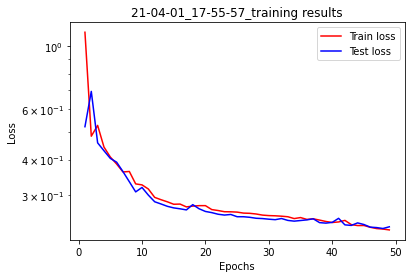

In [6]:
results_dir = os.path.join(basedir, "results", id)
checkpoints_dir = os.path.join(basedir, "models", id)
train_data_dir = os.path.join(basedir, "data", id, "train")
test_data_dir = os.path.join(basedir, "data", id, "test")
train_loss = np.loadtxt(os.path.join(results_dir, "train_loss.txt"))
test_loss = np.loadtxt(os.path.join(results_dir, "test_loss.txt"))
epochs = [i for i in range(1, train_loss.size + 1)]
plt.figure()
plt.plot(epochs, train_loss, "-r", label="Train loss")
plt.plot(epochs, test_loss, "-b", label="Test loss")
plt.title(id + "_training results")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.yscale("log")
plt.savefig(os.path.join(results_dir, "learning_curve.png"))

In [7]:
# pixels = 32
# x = np.arange(pixels) - pixels//2 + 0.5
# xx, yy = np.meshgrid(x, x)
# image = np.zeros((pixels, pixels))
# image += np.exp(-0.5 * np.hypot(xx + 5, yy - 5)**4/1**4)
# image += np.exp(-0.5 * np.hypot(xx - 5, yy + 5)**4/1**4)
# image /= image.sum()
# plt.imshow(image, origin="lower")

In [8]:
for X, Y in train_dataset:
    break

# image = image[np.newaxis, ..., np.newaxis]
image = Y
# X = phys.forward(tf.constant(image, tf.float32))
out, grad = rim.call(X)

In [58]:
index = 45

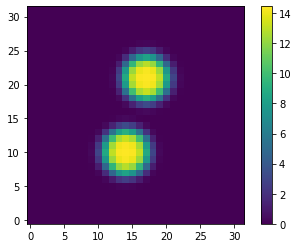

In [59]:
plt.imshow(Y[index, ..., 0], origin="lower")
plt.colorbar()

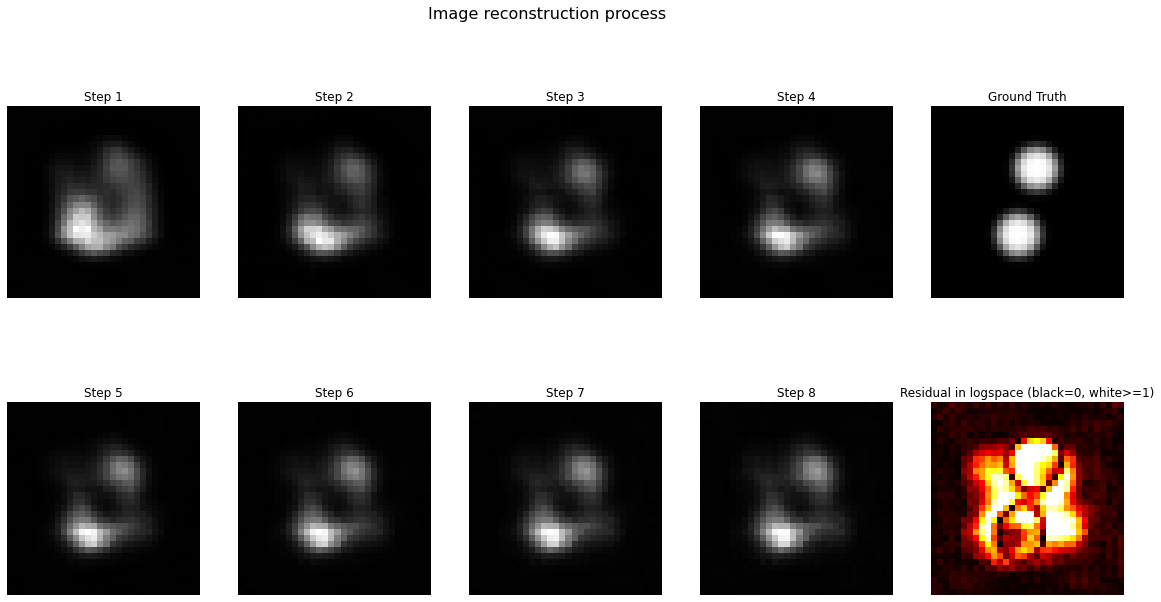

In [60]:
fig,axs = plt.subplots(2, 5, figsize=(20, 10))
k = 0
fig.suptitle("Image reconstruction process", fontsize=16)
for i in range(2):
  for j in range(5):
      if i == 0 and j == 4:
          axs[i, j].imshow(Y[index, ..., 0].numpy(), cmap="gray", origin="lower")
          axs[i, j].axis("off")
          axs[i, j].set_title(f"Ground Truth")
      elif i == 1 and j == 4:
          axs[i, j].imshow(np.abs(out[index, ..., 0, -1].numpy() - np.log(Y[index, ..., 0].numpy() + args.noise_floor)), cmap="hot", origin="lower", vmin=0, vmax=1)
          axs[i, j].axis("off")
          axs[i, j].set_title(f"Residual in logspace (black=0, white>=1)")
      else:
          axs[i, j].imshow(np.exp(out[index, ..., 0, k].numpy()), cmap="gray", origin="lower")
          axs[i, j].axis("off")
          axs[i, j].set_title(f"Step {k+1}")
          k += 1

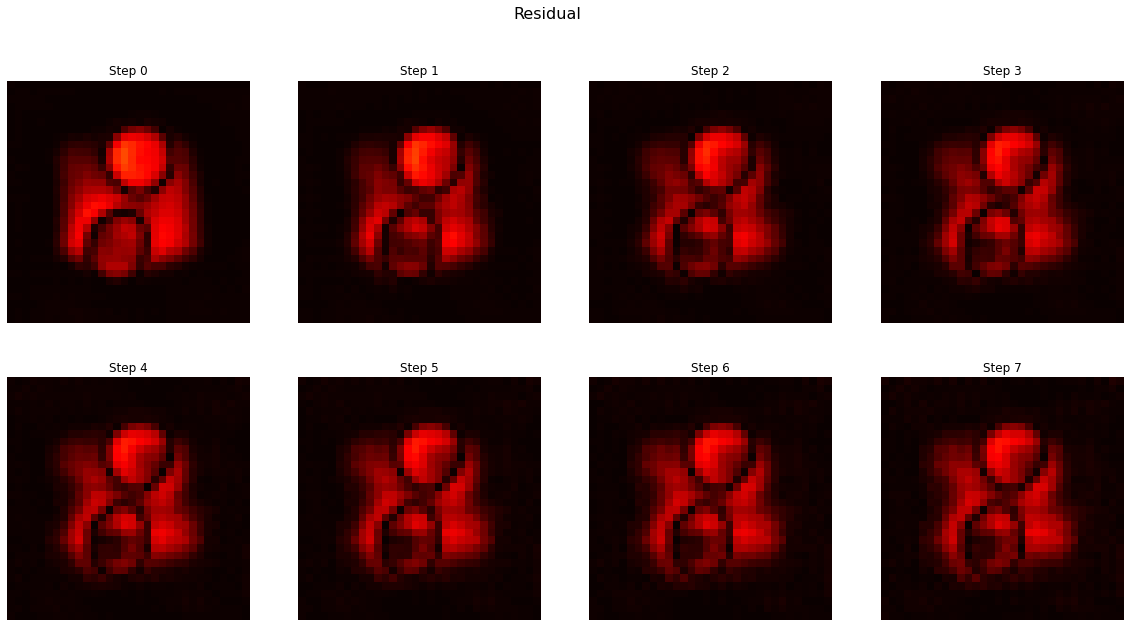

In [61]:
fig,axs = plt.subplots(2, 4, figsize=(20, 10))
k = 0
fig.suptitle("Residual", fontsize=16)
for i in range(2):
  for j in range(4):
    axs[i, j].imshow(np.abs(out[index, ..., 0, k].numpy() - np.log(Y[index, ..., 0].numpy() + args.noise_floor)), cmap="hot", origin="lower", vmin=0, vmax=4)
    axs[i, j].axis("off")
    axs[i, j].set_title(f"Step {k}")
    k += 1

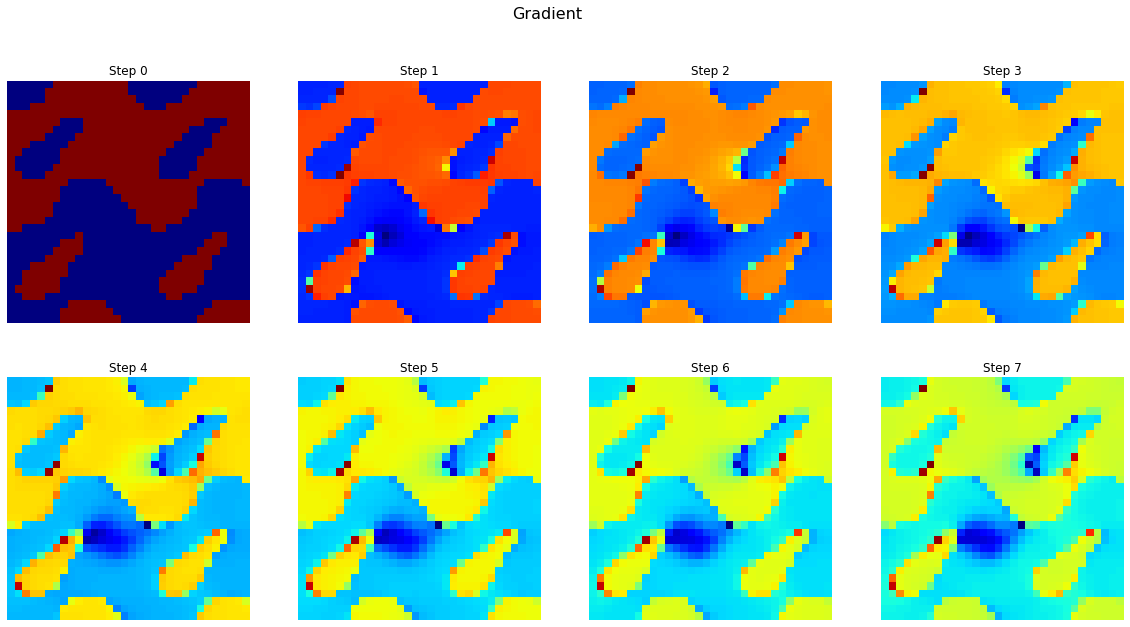

In [62]:
fig,axs = plt.subplots(2, 4, figsize=(20, 10))
k = 0
fig.suptitle("Gradient", fontsize=16)
for i in range(2):
  for j in range(4):
    axs[i, j].imshow(grad[index, ..., k].numpy(), cmap="jet", origin="lower")#, vmin=-1000, vmax=1000)
    axs[i, j].axis("off")
    axs[i, j].set_title(f"Step {k}")
    k += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'UV coverage')

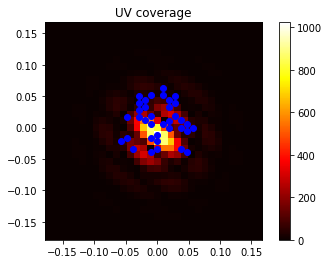

In [24]:
fft = np.abs(np.fft.fftshift(np.fft.fft2(image[0, ..., 0])))
# from exorim.interferometry.operators import Baselines
# from exorim.interferometry.models.direct_fourier_transform import GOLAY9
pixels=32
wavel = args.wavelength
uv = phys.baselines.UVC
rho = np.hypot(uv[:, 0], uv[:, 1])
fov = rad2mas(args.wavelength/rho).max()
plate_scale = fov / pixels # mas
fftfreq = np.fft.fftshift(np.fft.fftfreq(pixels, plate_scale))

im = plt.imshow(np.abs(fft), cmap="hot", extent=[fftfreq.min(), fftfreq.max()]*2)
baselines = Baselines(mask_coordinates=GOLAY9)
ufreq = 1/rad2mas(1/baselines.UVC[:, 0]*wavel)
vfreq = 1/rad2mas(1/baselines.UVC[:, 1]*wavel)
plt.plot(ufreq, vfreq, "bo")
plt.colorbar(im)
plt.title("UV coverage")

In [25]:
im = out[0, ..., 1]
im = tf.reshape(im, [1] + im.shape)
X = phys.forward(image)
amp = X[..., :phys.p]
cp = X[..., phys.p:]
print(chisq.chi_squared_amplitude(im, amp, phys))
print(chisq.chi_squared_closure_phasor(im, cp, phys))
# self.lam * entropy(image, self.prior) 

tf.Tensor(
[ 8700704.   6793581.5  7550503.   8199748.5 11975716.  12003918.
 14664834.   7483451.5  7321671.   6939671.  15677876.   7008380.5
  6667580.5 10787536.  11433550.  11344038.   9389305.   7716049.
  8287200.   9465344.   7486533.5 12445803.   9458105.   8545497.
  8527108.   7511925.5 10987728.   8134240.   7619898.5 14966514.
  8097978.5 11619564.  14498906.   6625968.   7118854.   6814208.5
  9427666.  13556748.   7759651.5  8607132.  12910614.   8422902.
 15330212.   8203237.5 10053266.   7059603.   9238917.   8251522.5
  7878826.5 11325975. ], shape=(50,), dtype=float32)
tf.Tensor(
[110.11918  102.89042   93.794174 137.509    129.74657   85.43504
  69.830635  96.79131  120.49837   91.43031   69.83063  137.63515
  89.26623  111.4568    84.33552  157.86569  150.07631  100.408554
 109.96195   94.5158    50.524544 119.07555   94.515884  91.78562
 108.35022   98.41193   97.140434 118.75957   67.93812   69.83063
 120.697914 142.164     84.10493  105.21516  175.61855  132.637

In [26]:
for X, Y in train_dataset:
    break

In [27]:
tf.exp(out[..., 0]).numpy().max()

11.667967